# Boosting Your Data Science Workflow with Dask: A Comprehensive Guide

### Introduction

When Wes McKinney started writing Pandas, he had a rule of thumb: for Pandas to work optimally, the machine's RAM size must be 5-10 times larger than the dataset in question. This rule was easy to follow around 2010 but it is 2023. 

In 2020 already, most real-world datasets could easily crash common everyday laptops and machines with their massive sizes. Predicting this problem long before it became such a burning issue, a solution was released in 2015.

Dask is an open-source library released by the developers of Anaconda to address the need for scalable and efficient computing on large datasets that exceed the memory capacity of a single machine.

This tutorial will give a thorough introduction to this library and its most important features like Data DataFrames, Arrays and Bags (yes, you read it right) interfaces.

### Setting Up Dask

Like any other library, Dask can be installed in three ways: conda, pip and from source.

Since this is an introductory article on Dask, we won't cover the last installation method, as it is for maintainers.

If you use Anaconda, Dask is included in your default installation (which is a mark of how popular the library is). If you wish to reinstall or upgrade it, you can use the `install` command:

```python
conda install dask
```

The PIP alternative of the above is the following:

```python
pip install "dask[complete]"
```

Adding the `[complete]` extension also installs the required dependencies of Dask, eliminating the need to install NumPy, Pandas and Tornado manually.

You can check if the installation was successful by looking at the library version:

```python
import dask

dask.__version__
```

```
'2023.5.0'
```

Most of your time spent working with Dask will be focused on three interfaces: Dask DataFrames, Arrays and Bag. Let's import them to use for the rest of the articlea along with `numpy` and `pandas`:

In [1]:
import dask.array as da
import dask.bag as db
import dask.dataframe as dd
import numpy as np
import pandas as pd

### Basic Concepts of Dask

On a high-level, you can think of Dask as a wrapper that extends the capabilities of traditional tools like Pandas, NumPy and Spark to handle larger-than-memory datasets.

When faced with large objects like larger-than-memory arrays (vectors) or matrices (dataframes), Dask breaks them up into chunks, also called partitions. 

For example, consider the array of 12 random numbers in both NumPy and Dask:

In [2]:
narr = np.random.rand(12)

narr

array([0.9261154 , 0.87774082, 0.87078873, 0.22309476, 0.24575174,
       0.04182393, 0.31476305, 0.04599283, 0.62354124, 0.97597454,
       0.23923457, 0.81201211])

In [3]:
darr = da.from_array(narr, chunks=3)

darr

dask.array<array, shape=(12,), dtype=float64, chunksize=(3,), chunktype=numpy.ndarray>

The image above shows that the Dask array contains 4 chunks as we set `chunks` to 3. Under the hood, each chunk is a NumPy array in itself.

Now, let's consider a much large example. We will create two 10k by 100k array (1 billion elements) and perform element-wise multiplication in both libraries and measure the performance:

In [8]:
# Create the NumPy arrays
arr1 = np.random.rand(10_000, 100_000)
arr2 = np.random.rand(10_000, 100_000)

# Create the Dask arrays
darr1 = da.from_array(arr1, chunks=(1_000, 10_000))
darr2 = da.from_array(arr2, chunks=(1_000, 10_000))

In [9]:
%%time

result_np = np.multiply(arr1, arr2)

CPU times: user 966 ms, sys: 2.2 s, total: 3.17 s
Wall time: 3.19 s


In [10]:
%%time

result_dask = da.multiply(darr1, darr2)

CPU times: user 5.94 ms, sys: 22 ms, total: 27.9 ms
Wall time: 94.8 ms


As you can see, Dask is about 34 times faster than NumPy. The performance gains will only be bigger as the computation and array size increases.

Dask uses similar approach of chunking and distributing these chunks across all available cores on your machine for other objects as well.

### Dask DataFrames

To fully appreciate the benefits Dask, we need a large dataset, one that is preferably over 1 GB in size. Downloading such a dataset to follow along in the tutorial isn't optimal for you, the reader. So, you can use [this script](https://gist.github.com/BexTuychiev/af8076016de7eb9d65d2038a1dd701ef) I put together that generates a synthetic 10 million-row data with 10 numeric and 10 categorical features.

The requirement is that you have a machine with at least 12 GB of RAM to run [the script](https://gist.github.com/BexTuychiev/af8076016de7eb9d65d2038a1dd701ef).

After you have the `large_dataset.csv` file in your workspace, you can load it with the `read_csv` function of Dask DataFrames interface, `dd`:

In [5]:
import dask.dataframe as dd

dask_df = dd.read_csv("data/large_dataset.csv")

dask_df.head()

,Numeric_0,Numeric_1,Numeric_2,Numeric_3,Numeric_4,Numeric_5,Numeric_6,Numeric_7,Numeric_8,Numeric_9,Categorical_0,Categorical_1,Categorical_2,Categorical_3,Categorical_4,Categorical_5,Categorical_6,Categorical_7,Categorical_8,Categorical_9
0,0.954029,0.196295,0.481501,0.497420,0.307428,0.927494,0.720794,0.424402,0.349461,0.699471,A,K,B,D,N,K,F,R,C,P
1,0.814167,0.379423,0.196857,0.619969,0.595017,0.478217,0.150928,0.580445,0.292682,0.607309,I,B,J,Y,J,A,R,C,I,P
2,0.929750,0.470328,0.359956,0.225859,0.659483,0.973900,0.992307,0.782623,0.545566,0.758020,L,C,N,K,C,R,N,R,A,L
3,0.318181,0.208561,0.515705,0.731841,0.668760,0.753527,0.617363,0.970797,0.775214,0.601348,S,J,E,J,G,G,E,Z,G,D
4,0.457664,0.496309,0.865614,0.732108,0.051825,0.934005,0.829954,0.583504,0.119855,0.640705,J,M,O,P,Y,Z,X,B,J,H


Even though the file is large, you will notice that the result is fetched almost instantaneously. For even larger files, you can specify the `blocksize` parameter which takes the number of bytes you want to break up the file into.

Like Dask Arrays contain chunks of small NumPy arrays, Dask is designed to arrange multiple small Pandas DataFrames along the row-index. 

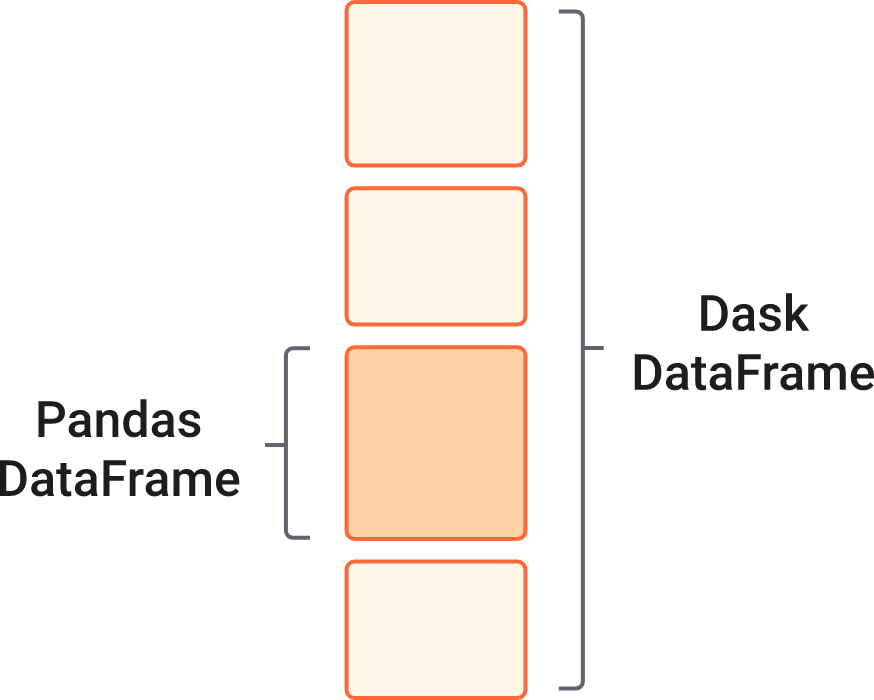

As you might guess from the `read_csv` function, most of the commonly used syntax and functionality of Pandas API are preserved in Dask. The following are some code blocks that should be familiar from your Pandas days (they are gone now, because you will be switching to Dask in no time).

__Selecting columns and element-wise operations__

In [8]:
result = (
    dask_df["Numeric_0"] + dask_df["Numeric_9"] * dask_df["Numeric_3"]
)
result.compute().head()

0    1.301960
1    1.190679
2    1.100955
3    0.758272
4    0.926729
dtype: float64

__Conditional filtering__

In [9]:
dask_df[dask_df["Categorical_5"] == "A"].compute().head()

,Numeric_0,Numeric_1,Numeric_2,Numeric_3,Numeric_4,Numeric_5,Numeric_6,Numeric_7,Numeric_8,Numeric_9,Categorical_0,Categorical_1,Categorical_2,Categorical_3,Categorical_4,Categorical_5,Categorical_6,Categorical_7,Categorical_8,Categorical_9
1,0.814167,0.379423,0.196857,0.619969,0.595017,0.478217,0.150928,0.580445,0.292682,0.607309,I,B,J,Y,J,A,R,C,I,P
9,0.421256,0.700283,0.252628,0.676640,0.814156,0.416240,0.413232,0.460071,0.866812,0.730768,S,N,L,K,Q,A,B,W,O,D
16,0.282811,0.719339,0.207320,0.976588,0.949429,0.080404,0.990779,0.072801,0.482127,0.163088,I,O,Z,X,A,A,T,M,J,V
18,0.483087,0.841133,0.025510,0.009140,0.183722,0.325491,0.290477,0.706761,0.589473,0.117201,J,K,W,J,M,A,N,F,V,P
35,0.192446,0.274116,0.708766,0.960327,0.227727,0.432471,0.227079,0.811245,0.092382,0.857535,M,D,Z,M,C,A,Y,D,C,O


__Common summary statistics__

In [11]:
dask_df.describe().compute()

,Numeric_0,Numeric_1,Numeric_2,Numeric_3,Numeric_4,Numeric_5,Numeric_6,Numeric_7,Numeric_8,Numeric_9
count,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07
mean,5.000694e-01,4.999880e-01,4.999234e-01,5.001617e-01,4.999199e-01,5.000784e-01,4.999988e-01,4.998237e-01,4.999092e-01,5.000875e-01
std,2.886411e-01,2.885834e-01,2.886858e-01,2.887104e-01,2.886306e-01,2.886403e-01,2.886713e-01,2.887814e-01,2.886391e-01,2.887165e-01
min,1.564002e-07,9.838086e-10,1.560742e-07,2.491680e-07,8.348743e-08,6.555190e-08,4.902090e-08,6.893530e-08,7.024191e-09,2.179944e-07
25%,2.511082e-01,2.520286e-01,2.511258e-01,2.520083e-01,2.510887e-01,2.519130e-01,2.513019e-01,2.512131e-01,2.518856e-01,2.517978e-01
50%,5.017100e-01,5.021449e-01,5.024578e-01,5.020417e-01,5.012735e-01,5.023080e-01,5.013113e-01,5.017622e-01,5.019776e-01,5.023563e-01
75%,7.514503e-01,7.510077e-01,7.518552e-01,7.517292e-01,7.512685e-01,7.516721e-01,7.516851e-01,7.516377e-01,7.518002e-01,7.522887e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.999998e-01,9.999998e-01,1.000000e+00,9.999999e-01,1.000000e+00


In [14]:
dask_df["Categorical_3"].value_counts().compute().head()

Categorical_3
O    386038
C    385804
A    385493
P    385490
K    385116
Name: count, dtype: int64

__Groupby__

In [18]:
dask_df.groupby("Categorical_8")["Numeric_7"].mean().compute().head()

Categorical_8
A    0.498497
B    0.499767
C    0.500622
D    0.500307
E    0.499530
Name: Numeric_7, dtype: float64

Check out [this section of Dask user guide](https://docs.dask.org/en/stable/dataframe.html#scope) on the rest of the familiarities between Pandas and Dask.

### Lazy evaluation

Now, I want to draw your attention to how I am ending each and every one of the above code blocks with `compute` function

### Dask Bags and Dask Delayed for Unstructured Data

### Dask Distributed: Parallel and Distributed Computing

### Best Practices for Using Dask

### Conclusion and Further Resources